In [18]:
# [1] 모듈 로딩
import pandas as pd
import seaborn as sns
import koreanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np

import holidays

# 대한민국 공휴일 정의 (예: 2023년)
kr_holidays = holidays.KR(years=[2024, 2025])  # 여러 해를 넣고 싶으면 [2023, 2024, 2025]처럼 리스트로

In [ ]:
# [1] 모듈 로딩
import pandas as pd
import numpy as np
import seaborn as sns
import koreanize_matplotlib
import matplotlib.pyplot as plt
import holidays

# %% [2] 데이터 불러오기 및 리샘플링
DATA = "./result/processed.csv"
DF = pd.read_csv(DATA, encoding='utf-8-sig', parse_dates=['시각'])

# datetime 처리
DF['시각'] = pd.to_datetime(DF['시각'])
DF.set_index('시각', inplace=True)

# ✅ 유량 컬럼은 sum, 나머지는 mean으로 리샘플링
sum_cols = [col for col in DF.columns if "유량" in col]
mean_cols = [col for col in DF.columns if col not in sum_cols]

agg_dict = {col: 'sum' for col in sum_cols}
agg_dict.update({col: 'mean' for col in mean_cols})

# 5분 단위 리샘플링
DF = DF.resample('5min').agg(agg_dict)

# 결측치 보간
DF = DF.ffill().bfill()

In [21]:
DATA_TEMP = './raw data/preprocessed_수원 기온 및 강수량_20240925_20250116.csv'

# CSV 불러오기
TEMP = pd.read_csv(
    DATA_TEMP,
    encoding='utf-8-sig',
    parse_dates=['일시'],
    usecols=lambda col: col not in ['Unnamed: 0', '지점', '지점명']
)

# datetime 설정
TEMP['일시'] = pd.to_datetime(TEMP['일시'])
TEMP.set_index('일시', inplace=True)

# 컬럼명 통일
TEMP.rename(columns={
    '기온(°C)': '기온',
    '강수량(mm)': '강수량'
}, inplace=True)

# 5분 단위 리샘플링: 기온 → 평균, 강수량 → 합계
TEMP = TEMP.resample('5min').agg({
    '기온': 'mean',
    '강수량': 'sum'
})

# 결측치 보간
TEMP = TEMP.ffill().bfill()

# 확인
TEMP.head()

,기온,강수량
일시,,
2024-09-25 00:00:00,17.6,0.0
2024-09-25 00:05:00,17.6,0.0
2024-09-25 00:10:00,17.6,0.0
2024-09-25 00:15:00,17.6,0.0
2024-09-25 00:20:00,17.6,0.0


In [22]:
print(DF.columns)

Index(['D_배수지_유출유량2', 'D_배수지_유입유량1', 'D_배수지_유입유량2', 'D_배수지_유출유량1',
       '나단계_D배수지_유입유량1', 'D_배수지_수위2', 'D_배수지_수위1', 'D_배수지_수위8', 'D_배수지_수위7',
       'D_배수지_유출개도2', 'D_배수지_유입개도2', 'D_배수지_유출개도1', 'D_배수지_유입개도1',
       'D_배수지_유입개도8', 'D_배수지_유입개도7', 'D_배수지_유입개도3', 'D_배수지_수위2_m3',
       'D_배수지_수위1_m3', 'D_배수지_수위8_m3', 'D_배수지_수위7_m3'],
      dtype='object')


In [23]:
print(DF.index.min(), DF.index.max())
print(TEMP.index.min(), TEMP.index.max())

2024-09-25 00:00:00 2025-01-16 00:00:00
2024-09-25 00:00:00 2025-01-16 23:00:00


In [ ]:
# %% [병합 실행]
# D_DF, D_TEMP는 이미 '시각' 또는 '일시'를 datetime 인덱스로 갖고 있음

# 1. 인덱스를 기준으로 병합
DF = DF.merge(TEMP, how='left', left_index=True, right_index=True)

# 2. 결과 확인
print("병합된 데이터프레임 크기:", DF.shape)
print(DF.columns)
print(DF.index.min(), "→", DF.index.max())

# # 3. 앞부분 미리보기
# display(DF.head())

# 4. 결측치 보간 (기온/강수량에서 생겼을 가능성 있음)
DF = DF.ffill().bfill()

In [25]:
# plt.figure(figsize=(14, 4))
# plt.plot(D_DF.index, D_DF['기온'], label='기온')
# plt.plot(D_DF.index, D_DF['강수량'], label='강수량')
# plt.legend()
# plt.title('기온 및 강수량 시계열')
# plt.xlabel('시간')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

| 컬럼명  | 의미              | 값 범위         | 용도       | 예시        |
| ---- | --------------- | ------------ | -------- | --------- |
| `시간` | 시(hour)         | 0 \~ 23      | 하루 주기 표현 | 새벽 3시 → 3 |
| `요일` | 요일              | 0(월) \~ 6(일) | 주간 주기 표현 | 금요일 → 4   |
| `월`  | 월(month)        | 1 \~ 12      | 계절성 반영   | 7월 → 7    |
| `일`  | 일(day of month) | 1 \~ 31      | 월간 주기 표현 | 15일 → 15  |


In [26]:
# 시간 기반 파생 피처
DF['시간'] = DF.index.hour
DF['분'] = DF.index.minute
DF['시간_float'] = DF['시간'] + DF['분'] / 60.0
DF['요일'] = DF.index.weekday
DF['월'] = DF.index.month
DF['일'] = DF.index.day

# 공휴일 리스트를 datetime64[ns] 타입으로 명시적으로 변환
holiday_dates = pd.to_datetime(list(kr_holidays))
DF['공휴일여부'] = DF.index.normalize().isin(holiday_dates).astype(int)

# Fourier 변환 함수 정의
def fourier_transform(series, period):
    radians = 2 * np.pi * series / period
    return np.sin(radians), np.cos(radians)

# Fourier 변환 -> sin(2πx / period), cos(2πx / period)
DF['시간_사인'], DF['시간_코사인'] = fourier_transform(DF['시간_float'], 24)
DF['요일_사인'], DF['요일_코사인'] = fourier_transform(DF['요일'], 7)
DF['일_사인'], DF['일_코사인'] = fourier_transform(DF['일'], 31)

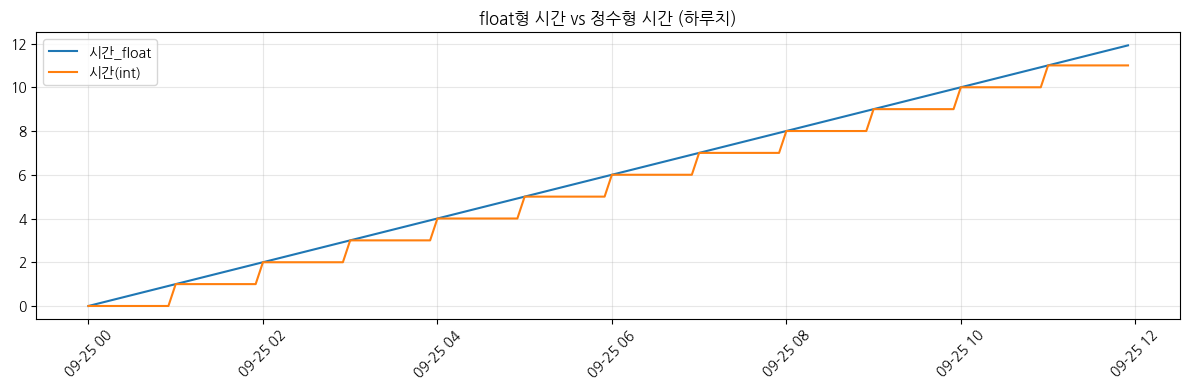

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(DF.index[:144], DF['시간_float'][:144], label='시간_float')
plt.plot(DF.index[:144], DF['시간'][:144], label='시간(int)')
plt.legend()
plt.title("float형 시간 vs 정수형 시간 (하루치)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
DF['시간_float'].head(20)
DF['시간_float'].tail(20)

시각
2025-01-15 22:25:00    22.416667
2025-01-15 22:30:00    22.500000
2025-01-15 22:35:00    22.583333
2025-01-15 22:40:00    22.666667
2025-01-15 22:45:00    22.750000
2025-01-15 22:50:00    22.833333
2025-01-15 22:55:00    22.916667
2025-01-15 23:00:00    23.000000
2025-01-15 23:05:00    23.083333
2025-01-15 23:10:00    23.166667
2025-01-15 23:15:00    23.250000
2025-01-15 23:20:00    23.333333
2025-01-15 23:25:00    23.416667
2025-01-15 23:30:00    23.500000
2025-01-15 23:35:00    23.583333
2025-01-15 23:40:00    23.666667
2025-01-15 23:45:00    23.750000
2025-01-15 23:50:00    23.833333
2025-01-15 23:55:00    23.916667
2025-01-16 00:00:00     0.000000
Freq: 5min, Name: 시간_float, dtype: float64

| 시각                  | 시간\_float (대상값) | 의미                 |
| ------------------- | --------------- | ------------------ |
| 2024-09-25 00:00:00 | 0.000           | 하루의 시작             |
| 2024-09-25 06:00:00 | 6.000           | 하루의 1/4 지점         |
| 2024-09-25 12:00:00 | 12.000          | 하루의 중간             |
| 2024-09-25 18:00:00 | 18.000          | 하루의 3/4 지점         |
| 2024-09-25 23:55:00 | 23.917          | 하루 거의 끝, 24시간에 가까움 |


In [29]:
DF['시간_사인'].head(20)

시각
2024-09-25 00:00:00    0.000000
2024-09-25 00:05:00    0.021815
2024-09-25 00:10:00    0.043619
2024-09-25 00:15:00    0.065403
2024-09-25 00:20:00    0.087156
2024-09-25 00:25:00    0.108867
2024-09-25 00:30:00    0.130526
2024-09-25 00:35:00    0.152123
2024-09-25 00:40:00    0.173648
2024-09-25 00:45:00    0.195090
2024-09-25 00:50:00    0.216440
2024-09-25 00:55:00    0.237686
2024-09-25 01:00:00    0.258819
2024-09-25 01:05:00    0.279829
2024-09-25 01:10:00    0.300706
2024-09-25 01:15:00    0.321439
2024-09-25 01:20:00    0.342020
2024-09-25 01:25:00    0.362438
2024-09-25 01:30:00    0.382683
2024-09-25 01:35:00    0.402747
Freq: 5min, Name: 시간_사인, dtype: float64

In [30]:
DF['시간_코사인'].tail()

시각
2025-01-15 23:40:00    0.996195
2025-01-15 23:45:00    0.997859
2025-01-15 23:50:00    0.999048
2025-01-15 23:55:00    0.999762
2025-01-16 00:00:00    1.000000
Freq: 5min, Name: 시간_코사인, dtype: float64

In [31]:
# ✅ Lag Feature 생성 함수: 과거 시점 값 그대로 복사 (누수 X)
def add_lag_features(df, columns, lags=[1, 2, 3]):
    result = {}
    for col in columns:
        for lag in lags:
            # col의 t-lag 값을 현재 시점에 입력 피처로 사용 (예: 유입유량1_lag1 = t-1 시점 값)
            result[f'{col}_lag{lag}'] = df[col].shift(lag)
    return result


# ✅ Diff Feature 생성 함수: 현재 시점 - 과거 시점 변화량 (누수 X)
def add_diff_features(df, columns, periods=[1, 2, 3]):
    result = {}
    for col in columns:
        for p in periods:
            # col(t) - col(t-p): 변화량, 미래 정보 포함 X → 누수 없음
            result[f'{col}_diff{p}'] = df[col].diff(p)
    return result


# ✅ Pct Change Feature 생성 함수: 현재와 과거 시점의 비율 변화량 (누수 X)
def add_pct_change_features(df, columns, periods=[1, 2, 3]):
    result = {}
    for col in columns:
        for p in periods:
            # (col(t) - col(t-p)) / col(t-p): 비율 변화, 시점상 안전함
            result[f'{col}_pct{p}'] = df[col].pct_change(p)
    return result


# ✅ Rolling Feature 생성 함수: 과거 window 길이만큼의 이동 평균 및 표준편차 (누수 X)
def add_rolling_features(df, columns, windows=[2, 3, 6, 12, 24, 36], std_only_cols=None):
    """
    windows: 각 윈도우 크기 (단위는 시계열 간격 기준, 예: 5분 간격이면 2 → 10분)
    std_only_cols: 표준편차는 특정 컬럼에만 적용 (옵션)
    """
    result = {}
    for col in columns:
        for w in windows:
            # 이동 평균: t ~ t-w+1까지의 과거 값 평균 (현재 포함, 미래 X → 안전)
            result[f'{col}_{w*5}분이동평균'] = df[col].rolling(window=w, min_periods=1).mean()

            # 이동 표준편차: 마찬가지로 과거 window 기준으로만 계산 (누수 없음)
            if std_only_cols and col in std_only_cols:
                result[f'{col}_{w*5}분이동표준편차'] = df[col].rolling(window=w, min_periods=1).std()
    return result


In [32]:
#상관계수가 0.95 이상이면 거의 동일한 변수이므로, A_배수지_유출유량1을 모델에서 제거하거나 lag 변수로만 남기는 게 안전함
# 유출유량1과 유출유량2 간 상관관계 확인
DF[['D_배수지_유출유량1', 'D_배수지_유출유량2']].corr()

,D_배수지_유출유량1,D_배수지_유출유량2
D_배수지_유출유량1,1.00000,0.91044
D_배수지_유출유량2,0.91044,1.00000


유출유량1 과 그에 연결된 수조 제외
타겟 = 체적 -> 수위 컬럼 삭제

<hr>
<hr>
<hr>

타겟이 체적이기 떄문에 기존 % 단위 수위 제거

유출유량1 , 수위1 m3, 수위2 m3

In [33]:
DF.drop(columns=['D_배수지_수위7', 'D_배수지_수위8', 'D_배수지_유출유량1', 'D_배수지_수위1', 'D_배수지_수위2', 'D_배수지_수위1_m3', 'D_배수지_수위2_m3'], inplace=True)

<hr>
<hr>
<hr>

In [34]:
DF.columns

Index(['D_배수지_유출유량2', 'D_배수지_유입유량1', 'D_배수지_유입유량2', '나단계_D배수지_유입유량1',
       'D_배수지_유출개도2', 'D_배수지_유입개도2', 'D_배수지_유출개도1', 'D_배수지_유입개도1',
       'D_배수지_유입개도8', 'D_배수지_유입개도7', 'D_배수지_유입개도3', 'D_배수지_수위8_m3',
       'D_배수지_수위7_m3', '기온', '강수량', '시간', '분', '시간_float', '요일', '월', '일',
       '공휴일여부', '시간_사인', '시간_코사인', '요일_사인', '요일_코사인', '일_사인', '일_코사인'],
      dtype='object')

**1. 수위 (level_columns)**  
- 시계열적 변화가 핵심 → lag, diff, rolling mean + std 모두 필요

- std는 흔들림(불안정성), diff는 변화율, rolling mean은 평형점 파악

**2. 개도율 (valve_columns)**  
- 제어 신호이기 때문에 값 자체가 바뀌는 지점이 중요

- → diff, rolling mean은 의미 있지만, pct_change는 해석 의미 없음
(개도율은 0~100% 고정값이라 비율 변화는 왜곡됨)
  
**3. 유입유량 (inflow_columns)**  
- 유입량은 변화량 + 비율 변화 둘 다 중요
- → 갑작스런 증가 = 사고, 점진적 상승 = 평시 수요 증가

- pct_change 사용 매우 적절

**4. 기온/강수량 (temp_columns)**  
- 외부 환경 요인이므로, 변화 자체보다 "기후 패턴"이 중요

- → rolling mean + std 중심  
(특히 6~36 윈도우는 일간/주간 패턴 탐지)

| 컬럼 그룹  | lag | diff | pct\_change | rolling\_mean | rolling\_std   |
| ------ | --- | ---- | ----------- | ------------- | -------------- |
| 수위     | ✅   | ✅    | ❌           | ✅             | ✅              |
| 개도율    | ✅   | ✅    | ❌           | ✅             | ❌ (제어라서 무의미)   |
| 유입유량   | ✅   | ✅    | ✅           | ✅             | ❌ (이미 pct 반영됨) |
| 기온/강수량 | ✅   | ❌    | ❌           | ✅ (중심)        | ✅ (변동성 중요)     |

In [35]:
# %% [컬럼 그룹]
level_columns = [col for col in DF.columns if '수위' in col]
inflow_columns = [col for col in DF.columns if '유량' in col]
temp_columns = ['기온','강수량']

# %% [적용]
feature_dict = {}

# 1. 체적 → lag, diff, rolling mean + std
feature_dict.update(add_lag_features(DF, level_columns))
feature_dict.update(add_diff_features(DF, level_columns))
feature_dict.update(add_rolling_features(DF, level_columns, windows=[2, 3], std_only_cols=level_columns))

# 3. 유입유량 → lag, diff, pct, rolling mean
feature_dict.update(add_lag_features(DF, inflow_columns))
feature_dict.update(add_diff_features(DF, inflow_columns))
feature_dict.update(add_pct_change_features(DF, inflow_columns))
feature_dict.update(add_rolling_features(DF, inflow_columns, windows=[2, 3]))

# 강수량: lag + rolling mean + std
feature_dict.update(add_lag_features(DF, temp_columns))
feature_dict.update(add_rolling_features(DF, temp_columns, windows=[2, 3, 6, 12, 24, 36]))

# %% [결합]
DF = pd.concat([DF, pd.DataFrame(feature_dict, index=DF.index)], axis=1)

print("✅ 전체 파생 피처 생성 완료. shape:", DF.shape)

✅ 전체 파생 피처 생성 완료. shape: (32545, 110)


In [36]:
import numpy as np

# 전체 NaN 개수 확인
print("전체 NaN 개수:", DF.isna().sum().sum())

# Inf가 포함된 셀 개수
print("Inf 값 개수:", np.isinf(DF).sum().sum())

# 너무 큰 값 확인 (예: 1e+10 이상)
print("매우 큰 값 개수 (>1e+10):", (DF > 1e10).sum().sum())


전체 NaN 개수: 385
Inf 값 개수: 57
매우 큰 값 개수 (>1e+10): 57


In [37]:
# NaN이 있는 컬럼 확인
nan_cols = DF.columns[DF.isna().any()]
print("NaN 포함 컬럼 수:", len(nan_cols))
print("NaN 포함 컬럼 목록:", list(nan_cols))

# Inf가 있는 컬럼 확인
inf_cols = DF.columns[np.isinf(DF).any()]
print("Inf 포함 컬럼 수:", len(inf_cols))
print("Inf 포함 컬럼 목록:", list(inf_cols))

NaN 포함 컬럼 수: 58
NaN 포함 컬럼 목록: ['D_배수지_수위8_m3_lag1', 'D_배수지_수위8_m3_lag2', 'D_배수지_수위8_m3_lag3', 'D_배수지_수위7_m3_lag1', 'D_배수지_수위7_m3_lag2', 'D_배수지_수위7_m3_lag3', 'D_배수지_수위8_m3_diff1', 'D_배수지_수위8_m3_diff2', 'D_배수지_수위8_m3_diff3', 'D_배수지_수위7_m3_diff1', 'D_배수지_수위7_m3_diff2', 'D_배수지_수위7_m3_diff3', 'D_배수지_수위8_m3_10분이동표준편차', 'D_배수지_수위8_m3_15분이동표준편차', 'D_배수지_수위7_m3_10분이동표준편차', 'D_배수지_수위7_m3_15분이동표준편차', 'D_배수지_유출유량2_lag1', 'D_배수지_유출유량2_lag2', 'D_배수지_유출유량2_lag3', 'D_배수지_유입유량1_lag1', 'D_배수지_유입유량1_lag2', 'D_배수지_유입유량1_lag3', 'D_배수지_유입유량2_lag1', 'D_배수지_유입유량2_lag2', 'D_배수지_유입유량2_lag3', '나단계_D배수지_유입유량1_lag1', '나단계_D배수지_유입유량1_lag2', '나단계_D배수지_유입유량1_lag3', 'D_배수지_유출유량2_diff1', 'D_배수지_유출유량2_diff2', 'D_배수지_유출유량2_diff3', 'D_배수지_유입유량1_diff1', 'D_배수지_유입유량1_diff2', 'D_배수지_유입유량1_diff3', 'D_배수지_유입유량2_diff1', 'D_배수지_유입유량2_diff2', 'D_배수지_유입유량2_diff3', '나단계_D배수지_유입유량1_diff1', '나단계_D배수지_유입유량1_diff2', '나단계_D배수지_유입유량1_diff3', 'D_배수지_유출유량2_pct1', 'D_배수지_유출유량2_pct2', 'D_배수지_유출유량2_pct3', 'D_배수지_유입유량1_pct1', 'D_배수지_유입유량1_pct2

In [38]:
# inf 값은 NaN으로 바꾸고
DF.replace([np.inf, -np.inf], np.nan, inplace=True)

# 결측값은 bfill → ffill 순으로 처리
DF = DF.bfill().ffill()

In [39]:
# 전체 NaN 개수 확인
print("전체 NaN 개수:", DF.isna().sum().sum())

# Inf가 포함된 셀 개수
print("Inf 값 개수:", np.isinf(DF).sum().sum())

# 너무 큰 값 확인 (예: 1e+10 이상)
print("매우 큰 값 개수 (>1e+10):", (DF > 1e10).sum().sum())


전체 NaN 개수: 0
Inf 값 개수: 0
매우 큰 값 개수 (>1e+10): 0


In [40]:
import os

# 저장할 폴더 경로
save_dir = "./result"

# 폴더가 없으면 자동 생성
os.makedirs(save_dir, exist_ok=True)

# 전체 저장 경로 구성
save_path = os.path.join(save_dir, "features.csv")

# 저장
DF.to_csv(save_path, index=True, encoding='utf-8-sig')
print(f"✅ 5분 리샘플링 이후 파생 피처 저장 완료: {save_path}")

✅ 5분 리샘플링 이후 파생 피처 저장 완료: ./result\features.csv


In [41]:
print(len(DF.columns))
# lag feature만 보기
lag_features = [col for col in DF.columns if '_lag' in col]
print(f"▶️ Lag Features ({len(lag_features)}개):")
print("\n".join(lag_features))

# diff feature만 보기
diff_features = [col for col in DF.columns if '_diff' in col]
print(f"\n▶️ Diff Features ({len(diff_features)}개):")
print("\n".join(diff_features))

# pct_change feature만 보기
pct_features = [col for col in DF.columns if '_pct' in col]
print(f"\n▶️ Percent Change Features ({len(pct_features)}개):")
print("\n".join(pct_features))

# rolling 평균 및 표준편차
rolling_features = [col for col in DF.columns if '이동' in col]
print(f"\n▶️ Rolling Features ({len(rolling_features)}개):")
print("\n".join(rolling_features))

# Fourier 시간 기반 피처
fourier_features = [col for col in DF.columns if '사인' in col or '코사인' in col]
print(f"\n▶️ Fourier Features ({len(fourier_features)}개):")
print("\n".join(fourier_features))

110
▶️ Lag Features (24개):
D_배수지_수위8_m3_lag1
D_배수지_수위8_m3_lag2
D_배수지_수위8_m3_lag3
D_배수지_수위7_m3_lag1
D_배수지_수위7_m3_lag2
D_배수지_수위7_m3_lag3
D_배수지_유출유량2_lag1
D_배수지_유출유량2_lag2
D_배수지_유출유량2_lag3
D_배수지_유입유량1_lag1
D_배수지_유입유량1_lag2
D_배수지_유입유량1_lag3
D_배수지_유입유량2_lag1
D_배수지_유입유량2_lag2
D_배수지_유입유량2_lag3
나단계_D배수지_유입유량1_lag1
나단계_D배수지_유입유량1_lag2
나단계_D배수지_유입유량1_lag3
기온_lag1
기온_lag2
기온_lag3
강수량_lag1
강수량_lag2
강수량_lag3

▶️ Diff Features (18개):
D_배수지_수위8_m3_diff1
D_배수지_수위8_m3_diff2
D_배수지_수위8_m3_diff3
D_배수지_수위7_m3_diff1
D_배수지_수위7_m3_diff2
D_배수지_수위7_m3_diff3
D_배수지_유출유량2_diff1
D_배수지_유출유량2_diff2
D_배수지_유출유량2_diff3
D_배수지_유입유량1_diff1
D_배수지_유입유량1_diff2
D_배수지_유입유량1_diff3
D_배수지_유입유량2_diff1
D_배수지_유입유량2_diff2
D_배수지_유입유량2_diff3
나단계_D배수지_유입유량1_diff1
나단계_D배수지_유입유량1_diff2
나단계_D배수지_유입유량1_diff3

▶️ Percent Change Features (12개):
D_배수지_유출유량2_pct1
D_배수지_유출유량2_pct2
D_배수지_유출유량2_pct3
D_배수지_유입유량1_pct1
D_배수지_유입유량1_pct2
D_배수지_유입유량1_pct3
D_배수지_유입유량2_pct1
D_배수지_유입유량2_pct2
D_배수지_유입유량2_pct3
나단계_D배수지_유입유량1_pct1
나단계_D배수지_유입유량1_pct2
나단계_D배수지_